# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 5)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2020


In [5]:
if year is None:
    year = cur_year

if last_month is None:
    if year == cur_year:
        last_month = 3
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

In [6]:
pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2020-PATH-Monthly-Ridership-Report.pdf'

In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'y1': 121.284, 'x1': 70.016, 'y2': 245.247, 'x2': 568.926},
 {'y1': 261.316, 'x1': 71.546, 'y2': 407.469, 'x2': 569.691},
 {'y1': 482.459, 'x1': 70.781, 'y2': 603.36, 'x2': 568.161},
 {'y1': 620.96, 'x1': 70.781, 'y2': 761.757, 'x2': 569.691}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[121.284, 70.016, 245.247, 568.926],
 [261.316, 71.546, 407.469, 569.691],
 [482.459, 70.781, 603.36, 568.161],
 [620.96, 70.781, 761.757, 569.691]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.


No module named 'jpype'


{1: [                    0          1        2       3       4       5
  0  Christopher Street    131,490    5,199   2,520   1,942   2,230
  1           9thStreet    125,331    4,477   3,510   2,802   3,030
  2          14thStreet    220,597    8,740   4,049   3,198   4,029
  3          23rdStreet    218,080    9,297   2,502   1,898   2,617
  4          33rdStreet    823,329   33,193  12,486  10,053  18,058
  5     UPTOWN SUBTOTAL  1,518,827   60,906  25,067  19,893  29,964
  6                 WTC  1,465,004   63,724  10,605  10,969  20,256
  7   NEW YORK SUBTOTAL  2,983,831  124,630  35,672  30,862  50,220,
                       0          1        2       3       4        5
  0               Newark    698,306   29,901   7,204   5,747    9,287
  1             Harrison    213,765    9,051   2,476   1,936    3,020
  2       Journal Square    653,829   25,986  11,610   9,312   12,214
  3         Grove Street    552,382   22,251   9,612   7,213    8,907
  4       Exchange Place    413,34

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables
Pg 9: 4 tables
Pg 10: 4 tables
Pg 11: 4 tables
Pg 12: 4 tables


12

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

,0,1,2,3,4,5,date
0,Christopher Street,"131,490","5,199","2,520","1,942","2,230",2020-01-01
1,9thStreet,"125,331","4,477","3,510","2,802","3,030",2020-01-01
2,14thStreet,"220,597","8,740","4,049","3,198","4,029",2020-01-01
3,23rdStreet,"218,080","9,297","2,502","1,898","2,617",2020-01-01
4,33rdStreet,"823,329","33,193","12,486","10,053","18,058",2020-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,"60,344","2,370","1,027",840,746,2020-12-01
5,Pavonia/ Newport,"75,072","2,578","2,372","1,950","1,061",2020-12-01
6,Hoboken,"103,395","3,938","2,234","1,756",797,2020-12-01
7,NEW JERSEY SUBTOTAL,"812,767","30,109","19,388","15,758","9,770",2020-12-01


In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

,station,total,avg weekday,avg sat,avg sun,avg holiday,month
0,Christopher Street,131490,5199,2520,1942,2230,2020-01-01
1,9thStreet,125331,4477,3510,2802,3030,2020-01-01
2,14thStreet,220597,8740,4049,3198,4029,2020-01-01
3,23rdStreet,218080,9297,2502,1898,2617,2020-01-01
4,33rdStreet,823329,33193,12486,10053,18058,2020-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,60344,2370,1027,840,746,2020-12-01
5,Pavonia/ Newport,75072,2578,2372,1950,1061,2020-12-01
6,Hoboken,103395,3938,2234,1756,797,2020-12-01
7,NEW JERSEY SUBTOTAL,812767,30109,19388,15758,9770,2020-12-01


In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

,station,avg daily,total weekday,total sat,total sun,total holiday,month
0,Christopher Street,4242,109184,10080,7766,4460,2020-01-01
1,9thStreet,4043,94024,14042,11206,6059,2020-01-01
2,14thStreet,7116,183548,16197,12794,8058,2020-01-01
3,23rdStreet,7035,195243,10010,7593,5234,2020-01-01
4,33rdStreet,26559,697057,49945,40211,36116,2020-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,1947,52132,4108,3358,746,2020-12-01
5,Pavonia/ Newport,2422,56723,9489,7799,1061,2020-12-01
6,Hoboken,3335,86635,8938,7025,797,2020-12-01
7,NEW JERSEY SUBTOTAL,26218,662411,77557,63029,9770,2020-12-01


In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2020-01-01 Christopher Street        4242         5199     2520     1942   
           9thStreet                 4043         4477     3510     2802   
           14thStreet                7116         8740     4049     3198   
           23rdStreet                7035         9297     2502     1898   
           33rdStreet               26559        33193    12486    10053   
...                                   ...          ...      ...      ...   
2020-12-01 Exchange Place            1947         2370     1027      840   
           Pavonia/ Newport          2422         2578     2372     1950   
           Hoboken                   3335         3938     2234     1756   
           NEW JERSEY SUBTOTAL      26218        30109    19388    15758   
           MONTHLY TOTAL            48049        55355    34924    28464   

                                avg holiday    total  total weekday  \
month      station                                                    
2020-01-01 Christopher Street          2230   131490         109184   
           9thStreet                   3030   125331          94024   
           14thStreet                  4029   220597         183548   
           23rdStreet                  2617   218080         195243   
           33rdStreet                 18058   823329         697057   
...                                     ...      ...            ...   
2020-12-01 Exchange Place               746    60344          52132   
           Pavonia/ Newport            1061    75072          56723   
           Hoboken                      797   103395          86635   
           NEW JERSEY SUBTOTAL         9770   812767         662411   
           MONTHLY TOTAL              18157  1489516        1217807   

                                total sat  total sun  total holiday  
month      station                                                   
2020-01-01 Christopher Street       10080       7766           4460  
           9thStreet                14042      11206           6059  
           14thStreet               16197      12794           8058  
           23rdStreet               10010       7593           5234  
           33rdStreet               49945      40211          36116  
...                                   ...        ...            ...  
2020-12-01 Exchange Place            4108       3358            746  
           Pavonia/ Newport          9489       7799           1061  
           Hoboken                   8938       7025            797  
           NEW JERSEY SUBTOTAL      77557      63029           9770  
           MONTHLY TOTAL           139697     113855          18157  

[204 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

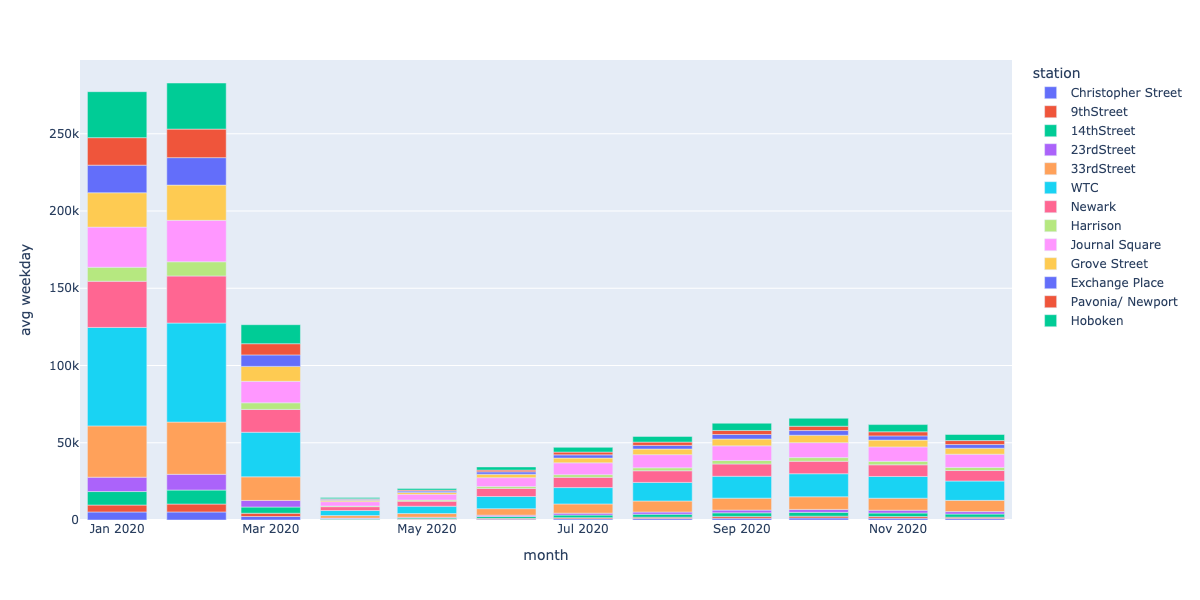

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))